In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import matplotlib.patheffects as path_effects
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')
import seaborn as sns
import fotmob_scraper as fms
from tqdm import tqdm
import requests
from PIL import Image
from io import BytesIO
from scipy.ndimage import gaussian_filter
import scipy.stats as stats
# mplsoccer 
from mplsoccer import VerticalPitch, Pitch

import matplotlib.colors as mcolors

from fast_poibin import PoiBin

from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import decimal_to_percent
from plottable.plots import image # image

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
df_teams = pd.read_csv('data/super_leagues_team_stats_2223.csv', index_col=0)
df_games = pd.read_csv('data/super_leagues_game_stats_2223.csv', index_col=0)
df_shots = pd.read_csv('data/super_leagues_shots_2223.csv', index_col=0)

In [3]:
team_colors: dict = {
    'BAS': '#FF1433', 
    'ZUR': '#00BFFF', 
    'GRA': '#0064B9', 
    'LAU': '#006EB7', 
    'LUG': '#000000', 
    'LUZ': '#154281', 
    'SER': '#870E26', 
    'SIO': '#EC1F00', 
    'GAL': '#008141',
    'YB': '#FFD940',
    'WIN':'#AB0707', 
    'AVG': '#FFFFFF'
}

In [4]:
team_logo_url = {
    'YB': "https://images.fotmob.com/image_resources/logo/teamlogo/10192.png", 
    'LUZ': "https://images.fotmob.com/image_resources/logo/teamlogo/10199.png", 
    'GAL': "https://images.fotmob.com/image_resources/logo/teamlogo/10190.png", 
    'LAU': "https://images.fotmob.com/image_resources/logo/teamlogo/7730.png", 
    'LUG': "https://images.fotmob.com/image_resources/logo/teamlogo/7896.png", 
    'ZUR': "https://images.fotmob.com/image_resources/logo/teamlogo/10243.png", 
    'GRA': "https://images.fotmob.com/image_resources/logo/teamlogo/9956.png", 
    'BAS': "https://images.fotmob.com/image_resources/logo/teamlogo/9931.png",
    'SER': "https://images.fotmob.com/image_resources/logo/teamlogo/9777.png",
    'SIO': "https://images.fotmob.com/image_resources/logo/teamlogo/10179.png",
    'WIN': "https://images.fotmob.com/image_resources/logo/teamlogo/7894.png"
    }

In [5]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [6]:
team_names = dict(zip(df_teams['team_short'],df_teams['team']))
team_names['BAS'] = 'FC Basel'
team_names['GRA'] = 'Grasshoppers\nZürich'
team_names['LUG'] = 'FC Lugano'
team_names['LUZ'] = 'FC Luzern'
team_names['SER'] = 'Servette FC'
team_names['SIO'] = 'FC Sion'
team_names['GAL'] = 'FC St. Gallen'
team_names['YB'] = 'BSC Young Boys'
team_names['WIN'] = 'FC Winterthur'

In [7]:
team_short = {
    'FC Zürich': 'ZUR', 
    'Young Boys': 'YB', 
    'Winterthur': 'WIN', 
    'Basel': 'BAS', 
    'Lugano': 'LUG', 
    'Sion': 'SIO',
    'St. Gallen': 'GAL',
    'Servette': 'SER',
    'Luzern': 'LUZ',
    'Grasshopper': 'GRA'
}

## xG rates for the 22/23 season

## xG vs. xGA / per game

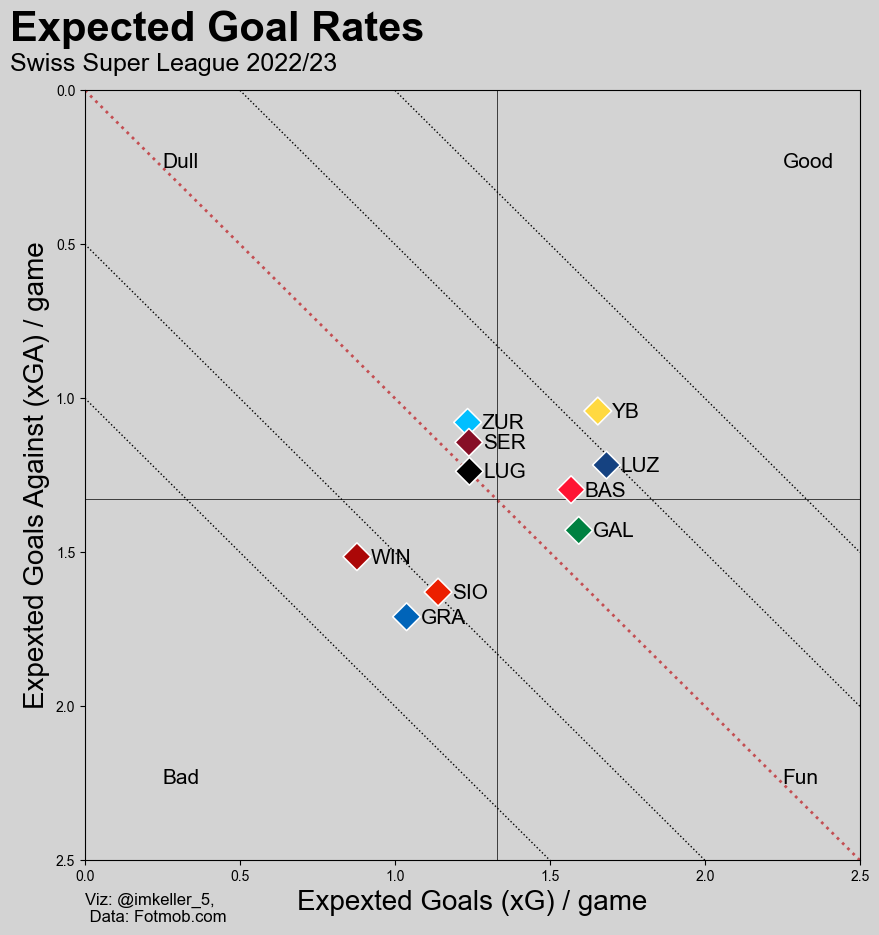

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

sns.set_theme(style="darkgrid")
sns.set_context("paper")

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.axvline(df_teams['expected_goals_against_(xga)_mean'].mean(), color=text_color, linewidth=0.5, zorder=5)
ax.axhline(df_teams['expected_goals_(xg)_mean'].mean(), color=text_color, linewidth=0.5, zorder=0)
sns.scatterplot(x='expected_goals_(xg)_mean', y='expected_goals_against_(xga)_mean',hue='team_short',palette=team_colors,data=df_teams, s=200,legend=False,marker='D',zorder=10)
ax.set_xlabel('Expexted Goals (xG) / game',fontsize=20,color=text_color)
ax.set_ylabel('Expexted Goals Against (xGA) / game',fontsize=20,color=text_color)

fig.text(0.05,0.93,'Expected Goal Rates', fontsize=30, color=text_color, fontweight='bold')
fig.text(0.05,0.90,'Swiss Super League {}'.format(season), fontweight='regular',fontsize=18,color=text_color)

ax.set_xlim(0,2.5)
ax.set_ylim(0,2.5)

ax.axline(xy1=(0, 0), slope=1, color='r', lw=2,ls='dotted')
ax.axline(xy1=(0.5, 0), slope=1, color=text_color, lw=1,ls='dotted')
ax.axline(xy1=(-0.5, 0), slope=1, color=text_color, lw=1,ls='dotted')
ax.axline(xy1=(1, 0), slope=1, color=text_color, lw=1,ls='dotted')
ax.axline(xy1=(-1, 0), slope=1, color=text_color, lw=1,ls='dotted')

ax.axes.invert_yaxis()

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)

for a in df_teams['team_short']:
    ax.annotate(a, (df_teams.loc[df_teams['team_short'] == a,'expected_goals_(xg)_mean'].values[0],df_teams.loc[df_teams['team_short'] == a,'expected_goals_against_(xga)_mean'].values[0]), xytext=(10,-5), textcoords='offset points', fontsize=15,color=text_color, zorder=100)

ax.annotate("Viz: @imkeller_5, \n Data: Fotmob.com", (0, 2.7), annotation_clip=False, fontsize=12,color=text_color)
ax.annotate("Good", (2.25, 0.25), annotation_clip=False, fontsize=15,color=text_color)
ax.annotate("Dull", (0.25, 0.25), annotation_clip=False, fontsize=15,color=text_color)
ax.annotate("Bad", (0.25, 2.25), annotation_clip=False, fontsize=15,color=text_color)
ax.annotate("Fun", (2.25, 2.25), annotation_clip=False, fontsize=15,color=text_color)

plt.show()

fig.savefig('figs/super_league_xg_rates_23_01_28.jpg',bbox_inches='tight')

##  Goals over expected vs. Goals against over expected

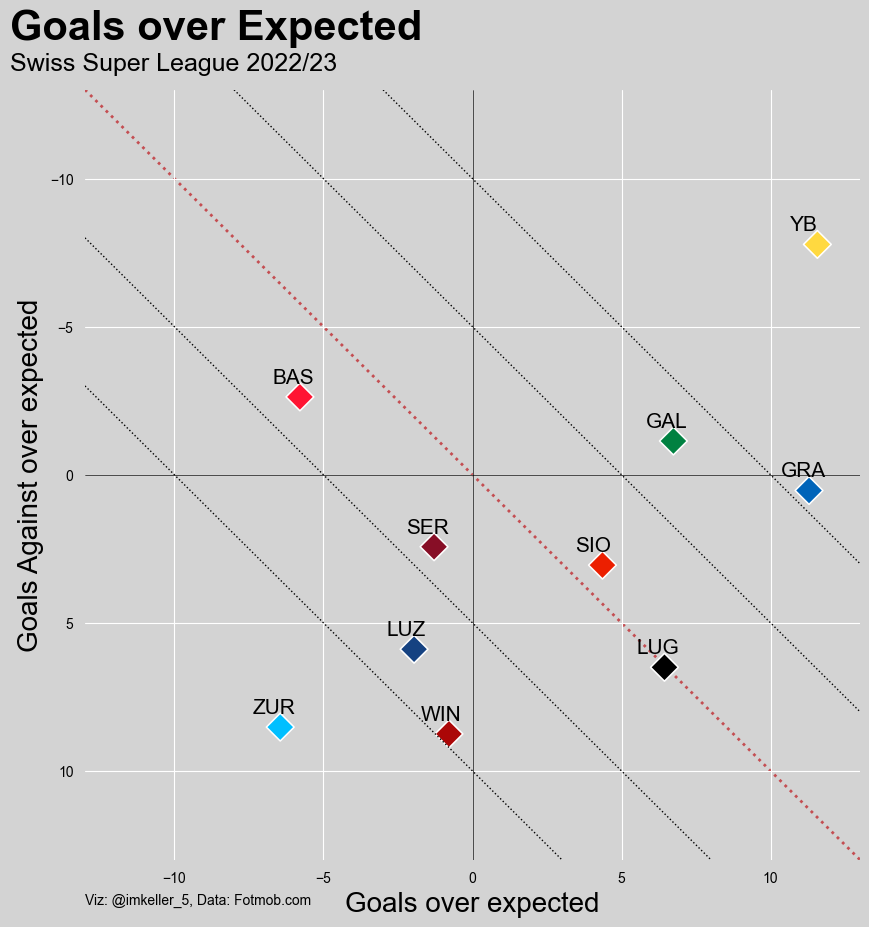

In [9]:
fig, ax = plt.subplots(figsize=(10,10))

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color  
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig.set_facecolor(background)
ax.patch.set_alpha(0)


sns.scatterplot(x=df_teams['goals_over_expected_sum'], y=df_teams['goals_against_over_expected_sum'],hue=df_teams['team_short'],palette=team_colors, s=200,legend=False,marker='D')
ax.set_xlabel('Goals over expected',fontsize=20, color=text_color)
ax.set_ylabel('Goals Against over expected',fontsize=20, color=text_color)
fig.text(0.05,0.93,'Goals over Expected', fontsize=30, color=text_color, fontweight='bold')
fig.text(0.05,0.90,'Swiss Super League {}'.format(season), fontweight='regular',fontsize=18, color=text_color)

ax.axvline(0, linewidth=0.5, color=text_color)
ax.axhline(0, linewidth=0.5, color=text_color)
ax.axline(xy1=(0, 0), slope=1, color='r', lw=2, ls='dotted', zorder=0)
ax.axline(xy1=(5, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)
ax.axline(xy1=(-5, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)
ax.axline(xy1=(10, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)
ax.axline(xy1=(-10, 0), slope=1, color=text_color, lw=1, ls='dotted', zorder=1)


ax.set_xlim(-13,13)
ax.set_ylim(-13,13)
ax.axes.invert_yaxis()

for a in df_teams['team_short']:
    ax.annotate(a, (df_teams.loc[df_teams['team_short'] == a,'goals_over_expected_sum'].values[0],df_teams.loc[df_teams['team_short'] == a,'goals_against_over_expected_sum'].values[0]), xytext=(-20,10), textcoords='offset points', fontsize=15,color=text_color)

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)

ax.annotate("Viz: @imkeller_5, Data: Fotmob.com", (-13, 14.5), annotation_clip=False, fontsize=10, color=text_color)
sns.set_theme(style="darkgrid")
sns.set_context("paper")
sns.despine(left=True, bottom=True)
plt.show()

fig.savefig('figs/super_league_goals_over_expected_23_01_28.jpg',bbox_inches='tight')

## rolling xG and xGA difference

In [10]:
df_games['xg_diff'] = df_games['expected_goals_(xg)'] - df_games['expected_goals_against_(xga)']

In [11]:
df_rolling = pd.DataFrame()
for team in df_games['team'].unique():
    df_rolling['{}'.format(df_games.loc[df_games['team']==team,"team_short"].values[0])]= df_games.loc[df_games['team']==team, ['match_round','xg_diff']].set_index('match_round').rolling(4,min_periods=1).sum()['xg_diff']

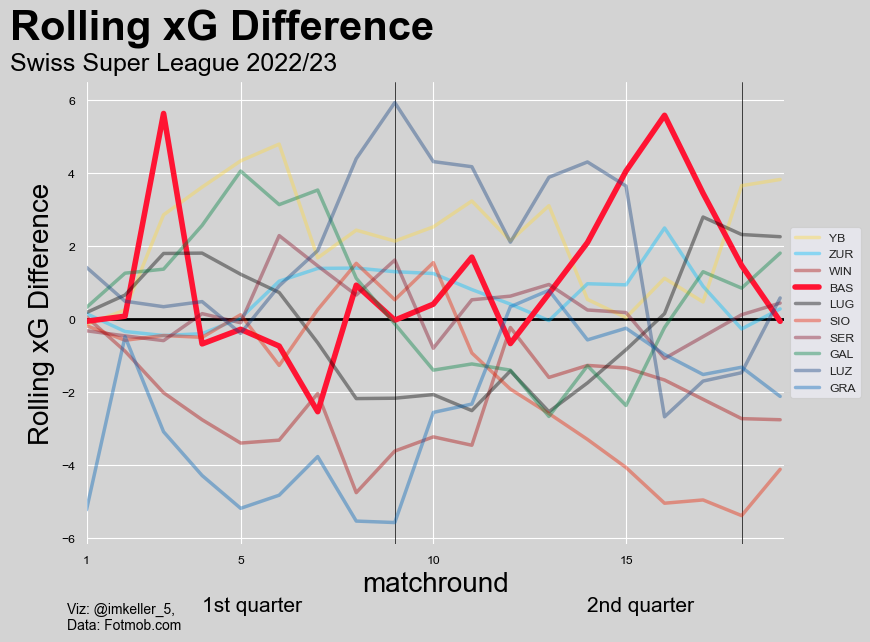

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
sns.set_palette("colorblind")
sns.set_theme(style="darkgrid")
sns.set_context("paper")

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "black"

mpl.rcParams['xtick.color'] = text_color  
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)
for team in df_games['team_short'].unique():
    if team in ['BAS']: 
        al = 1
        lw = 4
    else:
        al = 0.4
        lw = 2.5
    sns.lineplot(x=df_rolling.index, y=df_rolling[team], label=team, color=team_colors[team],zorder=30, alpha=al, linewidth=lw)

ax.axhline(0, linewidth=2,zorder=10,color=text_color)
ax.axvline(9, linewidth=0.5,zorder=5,color=text_color)
ax.axvline(18, linewidth=0.5,zorder=10,color=text_color)
ax.set_xlabel('matchround',fontsize=20, color=text_color)
ax.set_ylabel('Rolling xG Difference',fontsize=20, color=text_color)
fig.text(0.04,0.95,'Rolling xG Difference', fontsize=30, color=text_color, fontweight='bold')
fig.text(0.04,0.90,'Swiss Super League {}'.format(season), fontweight='regular',fontsize=18, color=text_color)
ax.annotate("Viz: @imkeller_5, \nData: Fotmob.com", (0.5,-8.5), annotation_clip=False, fontsize=10, color=text_color)
ax.annotate("1st quarter", (4, -8), annotation_clip=False, fontsize=15, color=text_color)
ax.annotate("2nd quarter", (14, -8), annotation_clip=False, fontsize=15, color=text_color)
#ax.annotate("3rd quarter", (19, -4.5), annotation_clip=False, fontsize=15, color=text_color)
ax.set_xticks([1, 5, 10, 15])
ax.set_xlim(1,19.1)
sns.despine(left=True, bottom=True)
ax.legend(loc="center left",bbox_to_anchor=(1, 0.5), frameon=True)

fig.savefig('figs/super_league_rolling_xg_difference_19_matchdays.jpg',bbox_inches='tight')

## Player Shotmaps

TODO:
- Goal & xG numbers and other infos on graphic 
- convex hull for most shots

In [13]:
df_shots.loc[df_shots['event_type']=='Goal','is_goal'] = 1
df_shots.loc[df_shots['event_type']!='Goal','is_goal'] = 0
df_shots_open_play = df_shots.loc[(df_shots['situation']!='FreeKick') & (df_shots['situation']!='SetPiece') &(df_shots['situation']!='Penalty'),:].copy()

['Jean Pierre Nsame', 'Hayao Kawabe', 'Cedric Itten', 'Emmanuel Latte Lath', 'Zan Celar', 'Filip Stojilkovic', 'Jeremy Guillemenot', 'Chadrac Akolo', 'Renat Dadashov', 'Giovanni Sio', 'Meschack Elia', 'Aiyegun Tosin', 'Matteo Di Giusto', 'Max Meyer', 'Bradley Fink', 'Renato Steffen', 'Mohamed Amoura', 'Andi Zeqiri', 'Mohamed Dräger', 'Miroslav Stevanovic']


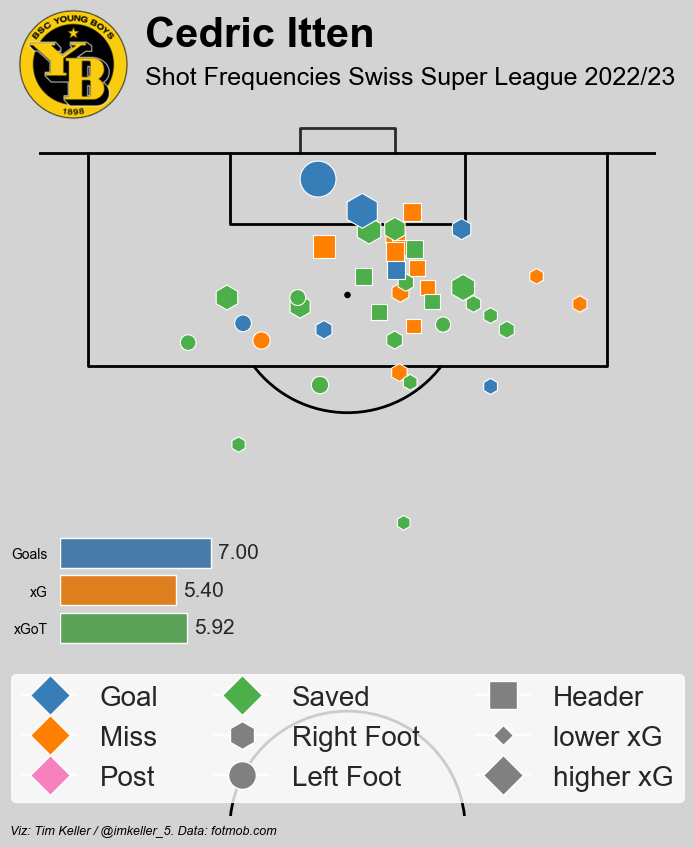

In [14]:
players = df_shots_open_play.loc[df_shots_open_play['event_type']=='Goal','player_name'].value_counts().head(20).index.tolist()
print(players)
player = players[2]

player_stats = df_shots_open_play.loc[df_shots_open_play['player_name']==player,['is_goal', 'expected_goals', 'expected_goals_on_target']]
player_stats_summed = player_stats.sum()

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

pitch = VerticalPitch('uefa',pad_bottom=-1, half=True, goal_type='box', goal_alpha=0.8, line_color=text_color, pad_left=-10, pad_right=-10)
fig, ax = pitch.draw(figsize=(9,7.5))
fig.set_facecolor(background)
ax.patch.set_alpha(0)


saved_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='h', ax=ax, zorder=15)
saved_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='o', ax=ax, zorder=15)
saved_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='AttemptSaved') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[2],edgecolors=edge,marker='s', ax=ax, zorder=15)

miss_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='h', ax=ax, zorder=5)
miss_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='o', ax=ax, zorder=5)
miss_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Miss') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[1],edgecolors=edge,marker='s', ax=ax, zorder=5)

post_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[3],edgecolors=edge,marker='h', ax=ax, zorder=10)
post_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[3],edgecolors=edge,marker='o', ax=ax, zorder=10)
post_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Post') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[3],edgecolors=edge,marker='s', ax=ax, zorder=10)

goals_right = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'RightFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='h', ax=ax, zorder=20)
goals_left = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'LeftFoot') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='o', ax=ax, zorder=20)
goals_header = pitch.scatter(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'x_coord'], df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'y_coord'], s=(df_shots_open_play.loc[(df_shots_open_play['event_type']=='Goal') & (df_shots_open_play['shot_type'] == 'Header') & (df_shots_open_play['player_name']== player),'expected_goals'] * 750) + 100, c=CB_color_cycle[0],edgecolors=edge,marker='s', ax=ax, zorder=20)

legend_elements = [
        lines.Line2D([0], [0], marker='D', color='w', label='Goal', markerfacecolor=CB_color_cycle[0], markersize=20),
        lines.Line2D([0], [0], marker='D', color='w', label='Miss', markerfacecolor=CB_color_cycle[1], markersize=20),
        lines.Line2D([0], [0], marker='D', color='w', label='Post', markerfacecolor=CB_color_cycle[3], markersize=20),
        lines.Line2D([0], [0], marker='D', color='w', label='Saved', markerfacecolor=CB_color_cycle[2], markersize=20),
        lines.Line2D([0], [0], marker='h', color='w', label='Right Foot', markerfacecolor='grey', markersize=20),
        lines.Line2D([0], [0], marker='o', color='w', label='Left Foot', markerfacecolor='grey', markersize=20),
        lines.Line2D([0], [0], marker='s', color='w', label='Header', markerfacecolor='grey', markersize=20),
        lines.Line2D([0,0], [0,1], marker='D', color='w', label='lower xG', markerfacecolor='grey', markersize=10),
        lines.Line2D([0,0], [0,1], marker='D', color='w', label='higher xG', markerfacecolor='grey', markersize=20)
       ]
legend = ax.legend(handles=legend_elements, loc='lower center', fontsize=10, prop={'size': 20}, ncol=3)
frame = legend.get_frame()
frame.set_color('white')

ax2 = fig.add_axes([0.12,0.95,0.15,0.15]) # badge
ax2.axis('off')
url = team_logo_url[df_shots.loc[df_shots['player_name']==player,'team_short'].unique()[0]]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

ax3 = fig.add_axes([0.18,0.25,0.6,0.15]) # badge
sns.set_style("white")
sns.set(font_scale=1)
sns.barplot(y=['Goals', 'xG', 'xGoT'], x=player_stats_summed, palette=CB_color_cycle, ax=ax3)
ax3.set_xlim(0,25)
sns.despine(left=True, bottom=True)
ax3.xaxis.set_visible(False)
ax3.bar_label(ax3.containers[0], fmt='%.2f', padding=5, fontsize=15)
ax3.set_facecolor(background)
#ax3.patch.set_alpha(0)


fig.text(0.125, 0.0, "Viz: Tim Keller / @imkeller_5. Data: fotmob.com",
        fontstyle="italic",fontsize=9,  color=text_color)


fig.text(0.275,1.05,player, fontsize=30, color=text_color, fontweight='bold')
fig.text(0.275,1,'Shot Frequencies Swiss Super League {}'.format(season), fontweight='regular',fontsize=18, color=text_color)

plt.tight_layout()
plt.show()

fig.savefig('figs/{}_shotmap.jpg'.format(player).lower().replace(' ','_'),bbox_inches='tight')

## Team Shotmaps
- Binned Shotmaps with zones on the field
- smaller binned shotmaps for goals? (to show finishing zones)

['ZUR' 'YB' 'WIN' 'BAS' 'LUG' 'SIO' 'GAL' 'SER' 'LUZ' 'GRA']


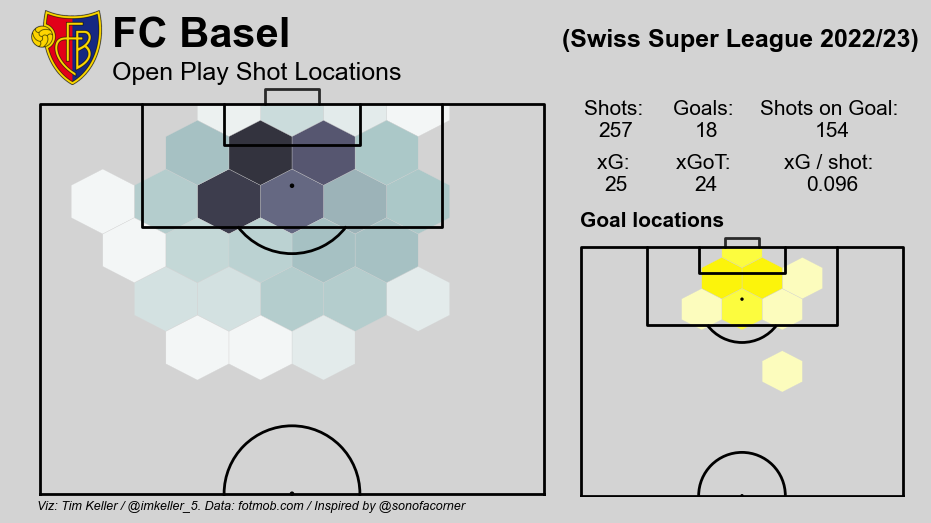

In [15]:
teams = df_shots_open_play['team_short'].unique()
print(teams)
team = teams[3]

df_shots_team = df_shots_open_play.loc[df_shots_open_play['team_short']==team]

season = "2022/23"
text_color = "black"
background = "#D3D3D3"

pitch = VerticalPitch(
    'uefa',
    pad_bottom=0.25,
    half=True, 
    goal_type='box', 
    goal_alpha=0.8, 
    linewidth=2,
    line_color=text_color,
    line_zorder=2
    )
fig, ax = pitch.draw(figsize=(6,5))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

bins = pitch.hexbin(
    x=df_shots_team['x_coord'], 
    y=df_shots_team['y_coord'], 
    ax=ax, 
    gridsize=(8,8), 
    zorder=-1, 
    cmap='bone_r', 
    alpha=0.9, 
    lw=.25,
    vmin=0,
    vmax=40,
    edgecolors=background    
    )

#cbar = fig.colorbar(bins, ax=ax, orientation='horizontal', pad=0.05, aspect=50, shrink=0.5)

ax2 = fig.add_axes([0.05,0.9,0.15,0.15]) # badge
ax2.axis('off')
url = team_logo_url[team]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

team_stats = df_shots_open_play.loc[df_shots_open_play['team_short']==team,['is_goal', 'expected_goals', 'expected_goals_on_target']]
team_stats_summed = team_stats.sum()
team_stats_summed['shots'] = df_shots_open_play.loc[df_shots_open_play['team_short']==team,['is_goal']].count().values[0]
team_stats_summed['shots_on_target'] = df_shots_open_play.loc[(df_shots_open_play['team_short']==team) & (df_shots_open_play['is_on_target']==True),['is_goal']].count().values[0]


#ax3 = fig.add_axes([1,0.75,0.6,0.15]) # badge
# sns.set_style("white")
# sns.set(font_scale=1)
# sns.barplot(y=['Goals', 'xG', 'xGoT', 'Shots'], x=team_stats_summed, palette=CB_color_cycle, ax=ax3)
# ax3.set_xlim(0,25)
# sns.despine(left=True, bottom=True)
# ax3.xaxis.set_visible(False)
# ax3.bar_label(ax3.containers[0], fmt='%.2f', padding=5, fontsize=15)
# ax3.set_facecolor(background)
# ax3.patch.set_alpha(0)



ax4 = fig.add_axes([0.95,0.045,0.6,0.6]) # badge
df_goals_team = df_shots_team.loc[df_shots_team['is_goal']==1]

pitch = VerticalPitch(
    'uefa',
    pad_bottom=0.25,
    #pad_left=-5,
    #pad_right=-5,
    half=True, 
    goal_type='box', 
    goal_alpha=0.8, 
    linewidth=2,
    line_color=text_color,
    line_zorder=2
    )
pitch.draw(figsize=(6,5), ax=ax4)
ax4.patch.set_alpha(0)


bins = pitch.hexbin(
    x=df_goals_team['x_coord'], 
    y=df_goals_team['y_coord'], 
    ax=ax4, 
    gridsize=(8,8), 
    zorder=-1, 
    cmap='hot_r', 
    alpha=0.95, 
    lw=.25,
    vmin=0,
    vmax=15,
    edgecolors=background    
    )

#cbar2 = fig.colorbar(bins, ax=ax4, orientation='horizontal', pad=-0.25, aspect=50, shrink=0.6)

ax4.annotate('Shots: \n{}'.format(round(team_stats_summed['shots'])), xy=(0.15, 1.4), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('Goals: \n{}'.format(round(team_stats_summed['is_goal'])), xy=(0.4, 1.4), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('Shots on Goal: \n{}'.format(round(team_stats_summed['shots_on_target'])), xy=(0.75, 1.4), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('xG: \n{}'.format(round(team_stats_summed['expected_goals'])), xy=(0.15, 1.2), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('xGoT: \n{}'.format(round(team_stats_summed['expected_goals_on_target'])), xy=(0.4, 1.2), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('xG / shot: \n{}'.format(round(team_stats_summed['expected_goals']/team_stats_summed['shots'],3)), xy=(0.75, 1.2), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')

ax4.annotate('Goal locations', xy=(0.25, 1.025), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center', fontweight='bold')

fig.text(0.075, 0.05, "Viz: Tim Keller / @imkeller_5. Data: fotmob.com / Inspired by @sonofacorner",
        fontstyle="italic",fontsize=9,  color=text_color)


fig.text(0.2,0.975,team_names[team], fontsize=30, color=text_color, fontweight='bold')
fig.text(0.95,0.975,'(Swiss Super League {})'.format(season), fontweight='heavy',fontsize=18, color=text_color)
fig.text(0.2,0.91,'Open Play Shot Locations', fontweight='regular',fontsize=18, color=text_color)


plt.show()
fig.savefig('figs/{}_{}_shot_locations.png'.format(team, season.replace("/", "_")), dpi=300, bbox_inches='tight', pad_inches=0.1)

['FC Zürich' 'Young Boys' 'Winterthur' 'Basel' 'Lugano' 'Sion'
 'St. Gallen' 'Servette' 'Luzern' 'Grasshopper']


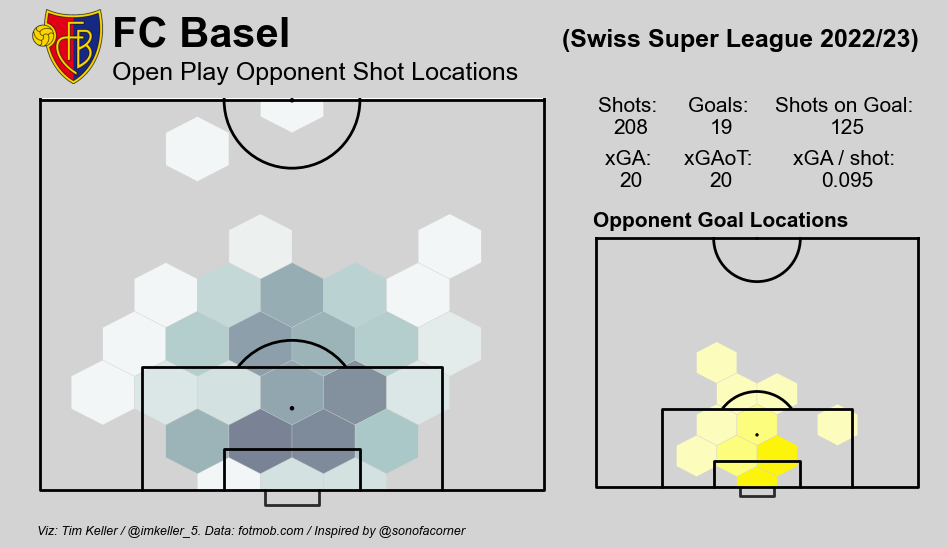

In [16]:
teams = df_shots_open_play['team'].unique()
print(teams)
team = teams[3]

df_shots_against_team = df_shots_open_play.loc[df_shots_open_play['opponent_team']==team]

season = "2022/23"
text_color = "black"
background = "#D3D3D3"

pitch = VerticalPitch(
    'uefa',
    pad_bottom=0.25,
    half=True, 
    goal_type='box', 
    goal_alpha=0.8, 
    linewidth=2,
    line_color=text_color,
    line_zorder=2
    )
fig, ax = pitch.draw(figsize=(6,5))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

bins = pitch.hexbin(
    x=df_shots_against_team['x_coord'], 
    y=df_shots_against_team['y_coord'], 
    ax=ax, 
    gridsize=(8,8), 
    zorder=-1, 
    cmap='bone_r', 
    alpha=0.9, 
    lw=.25,
    vmin=0,
    vmax=40,
    edgecolors=background    
    )

ax.invert_xaxis()
ax.invert_yaxis()

#cbar = fig.colorbar(bins, ax=ax, orientation='horizontal', pad=0.05, aspect=50, shrink=0.5)

ax2 = fig.add_axes([0.05,0.95,0.15,0.15]) # badge
ax2.axis('off')
url = team_logo_url[team_short[team]]
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

team_stats = df_shots_open_play.loc[df_shots_open_play['opponent_team']==team,['is_goal', 'expected_goals', 'expected_goals_on_target']]
team_stats_summed = team_stats.sum()
team_stats_summed['shots'] = df_shots_open_play.loc[df_shots_open_play['opponent_team']==team,['is_goal']].count().values[0]
team_stats_summed['shots_on_target'] = df_shots_open_play.loc[(df_shots_open_play['opponent_team']==team) & (df_shots_open_play['is_on_target']==True),['is_goal']].count().values[0]


#ax3 = fig.add_axes([1,0.75,0.6,0.15]) # badge
# sns.set_style("white")
# sns.set(font_scale=1)
# sns.barplot(y=['Goals', 'xG', 'xGoT', 'Shots'], x=team_stats_summed, palette=CB_color_cycle, ax=ax3)
# ax3.set_xlim(0,25)
# sns.despine(left=True, bottom=True)
# ax3.xaxis.set_visible(False)
# ax3.bar_label(ax3.containers[0], fmt='%.2f', padding=5, fontsize=15)
# ax3.set_facecolor(background)
# ax3.patch.set_alpha(0)



ax4 = fig.add_axes([0.975,0.075,0.6,0.6]) # badge
df_goals_team = df_shots_against_team.loc[df_shots_against_team['is_goal']==1]

pitch = VerticalPitch(
    'uefa',
    pad_bottom=0.25,
    #pad_left=-5,
    #pad_right=-5,
    half=True, 
    goal_type='box', 
    goal_alpha=0.8, 
    linewidth=2,
    line_color=text_color,
    line_zorder=2
    )
pitch.draw(figsize=(6,5), ax=ax4)
ax4.patch.set_alpha(0)


bins = pitch.hexbin(
    x=df_goals_team['x_coord'], 
    y=df_goals_team['y_coord'], 
    ax=ax4, 
    gridsize=(8,8), 
    zorder=-1, 
    cmap='hot_r', 
    alpha=0.95, 
    lw=.25,
    vmin=0,
    vmax=15,
    edgecolors=background    
    )

#cbar2 = fig.colorbar(bins, ax=ax4, orientation='horizontal', pad=-0.25, aspect=50, shrink=0.6)

ax4.annotate('Shots: \n{}'.format(round(team_stats_summed['shots'])), xy=(0.15, 1.45), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('Goals: \n{}'.format(round(team_stats_summed['is_goal'])), xy=(0.4, 1.45), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('Shots on Goal: \n{}'.format(round(team_stats_summed['shots_on_target'])), xy=(0.75, 1.45), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('xGA: \n{}'.format(round(team_stats_summed['expected_goals'])), xy=(0.15, 1.25), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('xGAoT: \n{}'.format(round(team_stats_summed['expected_goals_on_target'])), xy=(0.4, 1.25), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')
ax4.annotate('xGA / shot: \n{}'.format(round(team_stats_summed['expected_goals']/team_stats_summed['shots'],3)), xy=(0.75, 1.25), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center')

ax4.annotate('Opponent Goal Locations', xy=(0.4, 1.06), xycoords='axes fraction', fontsize=15, color=text_color, ha='center', va='center', fontweight='bold')

ax4.invert_xaxis()
ax4.invert_yaxis()

fig.text(0.075, 0.05, "Viz: Tim Keller / @imkeller_5. Data: fotmob.com / Inspired by @sonofacorner",
        fontstyle="italic",fontsize=9,  color=text_color)


fig.text(0.2,1.025,team_names[team_short[team]], fontsize=30, color=text_color, fontweight='bold')
fig.text(0.95,1.025,'(Swiss Super League {})'.format(season), fontweight='heavy',fontsize=18, color=text_color)
fig.text(0.2,0.96,'Open Play Opponent Shot Locations', fontweight='regular',fontsize=18, color=text_color)


plt.show()

fig.savefig('figs/{}_{}_opponent_shot_locations.png'.format(team_short[team], season.replace("/", "_")), dpi=300, bbox_inches='tight', pad_inches=0.1)

In [17]:
df_shots_open_play.loc[df_shots_open_play['team_short']==team,['is_goal']].count().values[0]

0

In [18]:
df_shots_open_play.head()

,shot_id,event_type,team_id,player_id,player_name,x_coord,y_coord,minutes,minutes_added,is_blocked,is_on_target,blocked_x_coord,blocked_y_coord,goal_crossed_y_coord,goal_crossed_z_coord,expected_goals,expected_goals_on_target,shot_type,situation,period,is_own_goal,first_name,last_name,teamColor,on_goal_shot_x_coord,on_goal_shot_y_coord,on_goal_shot_zoom_ratio,match_id,team,team_short,opponent_id,opponent_team,keeper_shot_faced,is_goal
0,2436814335,AttemptSaved,10243,841395,Aiyegun Tosin,88.392649,38.200237,2,0.0,False,True,103.198276,34.99125,35.525000,0.205474,0.062617,0.0968,RightFoot,RegularPlay,FirstHalf,False,Aiyegun,Tosin,#18B8E8,5.965608e-01,0.054358,1.000000,3905393,FC Zürich,ZUR,10192,Young Boys,von Ballmoos,0.0
2,2436820417,Miss,10192,694060,Meschack Elia,86.138239,33.466249,19,0.0,False,False,NaN,NaN,41.141905,1.695158,0.079011,NaN,RightFoot,RegularPlay,FirstHalf,False,Meschack,Elia,#000000,-2.220446e-16,0.237354,0.529271,3905393,Young Boys,YB,10243,FC Zürich,Brecher,0.0
3,2436820591,AttemptSaved,10243,976577,Bledian Krasniqi,74.939324,46.523057,20,0.0,False,True,102.629310,35.22000,33.390000,0.693474,0.010478,0.0225,LeftFoot,RegularPlay,FirstHalf,False,Bledian,Krasniqi,#18B8E8,1.161376e+00,0.183459,1.000000,3905393,FC Zürich,ZUR,10192,Young Boys,von Ballmoos,0.0
4,2436820967,AttemptSaved,10192,694060,Meschack Elia,87.641173,34.533751,21,0.0,True,True,91.000000,34.38125,33.847500,1.220000,0.087000,NaN,LeftFoot,RegularPlay,FirstHalf,False,Meschack,Elia,#000000,1.040344e+00,0.322751,1.000000,3905393,Young Boys,YB,10243,FC Zürich,Brecher,0.0
5,2436823955,AttemptSaved,10192,618774,Christian Fassnacht,100.163795,21.617071,31,0.0,True,True,101.681034,25.76500,35.143750,1.220000,0.130539,NaN,LeftFoot,RegularPlay,FirstHalf,False,Christian,Fassnacht,#000000,6.974206e-01,0.322751,1.000000,3905393,Young Boys,YB,10243,FC Zürich,Brecher,0.0


In [19]:
df_shots_open_play.loc[df_shots_open_play['team_short']==team,['is_goal']].count().values[0]


0

In [20]:
df_shots['opponent_team'].unique()

array(['Young Boys', 'FC Zürich', 'Basel', 'Winterthur', 'Sion', 'Lugano',
       'Servette', 'St. Gallen', 'Luzern', 'Grasshopper'], dtype=object)

## Goalkeeper Stats

In [21]:
df_goalies = df_shots_open_play.groupby(['keeper_shot_faced','opponent_team']).sum().reset_index().rename(columns={'keeper_shot_faced':'keeper', 'is_goal':'goals', 'opponent_team':'team'})[['keeper','expected_goals','expected_goals_on_target','goals', 'team']]
df_goalies = df_goalies.merge(df_shots_open_play.groupby('keeper_shot_faced').count().reset_index()[['keeper_shot_faced','shot_id']].rename(columns={'keeper_shot_faced':'keeper','shot_id':'shots_faced'}), on='keeper')

/var/folders/ts/3wmv3bq14n37zqx8km69cxtm0000gn/T/ipykernel_44165/3125903328.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_goalies = df_shots_open_play.groupby(['keeper_shot_faced','opponent_team']).sum().reset_index().rename(columns={'keeper_shot_faced':'keeper', 'is_goal':'goals', 'opponent_team':'team'})[['keeper','expected_goals','expected_goals_on_target','goals', 'team']]


In [22]:
teams_short = dict()
for team in df_goalies.team.unique():
    teams_short[team] = df_shots.loc[df_shots['team']==team,'team_short'].unique()[0]

In [23]:
df_goalies['team_short'] = df_goalies['team'].map(teams_short)

In [24]:
df_goalies['goals_saved_above_expected'] = df_goalies['expected_goals_on_target'] - df_goalies['goals']
df_goalies

,keeper,expected_goals,expected_goals_on_target,goals,team,shots_faced,team_short,goals_saved_above_expected
0,Ati-Zigi,20.618414,24.1260,19.0,St. Gallen,202,GAL,5.1260
1,Brecher,16.847027,24.3982,25.0,FC Zürich,189,ZUR,-0.6018
2,Fayulu,13.742151,14.8211,17.0,Winterthur,133,WIN,-2.1789
3,Frick,19.446619,16.2014,19.0,Servette,263,SER,-2.7986
4,Hammel,10.851997,9.5517,13.0,Grasshopper,119,GRA,-3.4483
5,Hitz,19.074133,19.1370,18.0,Basel,197,BAS,1.1370
6,Kostadinovic,1.610031,2.0432,1.0,FC Zürich,14,ZUR,1.0432
7,Kuster,3.344440,2.7632,4.0,Winterthur,32,WIN,-1.2368
8,Lindner,23.199011,22.5189,28.0,Sion,233,SIO,-5.4811
9,Loretz,0.541300,0.5845,0.0,Luzern,12,LUZ,0.5845


In [25]:
df_goalies_ranking = df_goalies[df_goalies['shots_faced'] >= 50].sort_values('goals_saved_above_expected', ascending=False).reset_index(drop=True)

In [26]:
df_goalies_ranking.head()

,keeper,expected_goals,expected_goals_on_target,goals,team,shots_faced,team_short,goals_saved_above_expected
0,Ati-Zigi,20.618414,24.1260,19.0,St. Gallen,202,GAL,5.1260
1,Moreira,16.857254,16.2427,15.0,Grasshopper,172,GRA,1.2427
2,Hitz,19.074133,19.1370,18.0,Basel,197,BAS,1.1370
3,von Ballmoos,11.335037,9.1312,8.0,Young Boys,142,YB,1.1312
4,Brecher,16.847027,24.3982,25.0,FC Zürich,189,ZUR,-0.6018


In [27]:
df_goalies_plot = pd.melt(df_goalies_ranking[['keeper', 'expected_goals_on_target','goals']], id_vars=['keeper'], value_vars=['expected_goals_on_target', 'goals'], var_name='metric', value_name='value')

In [28]:
mcolors.TABLEAU_COLORS

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

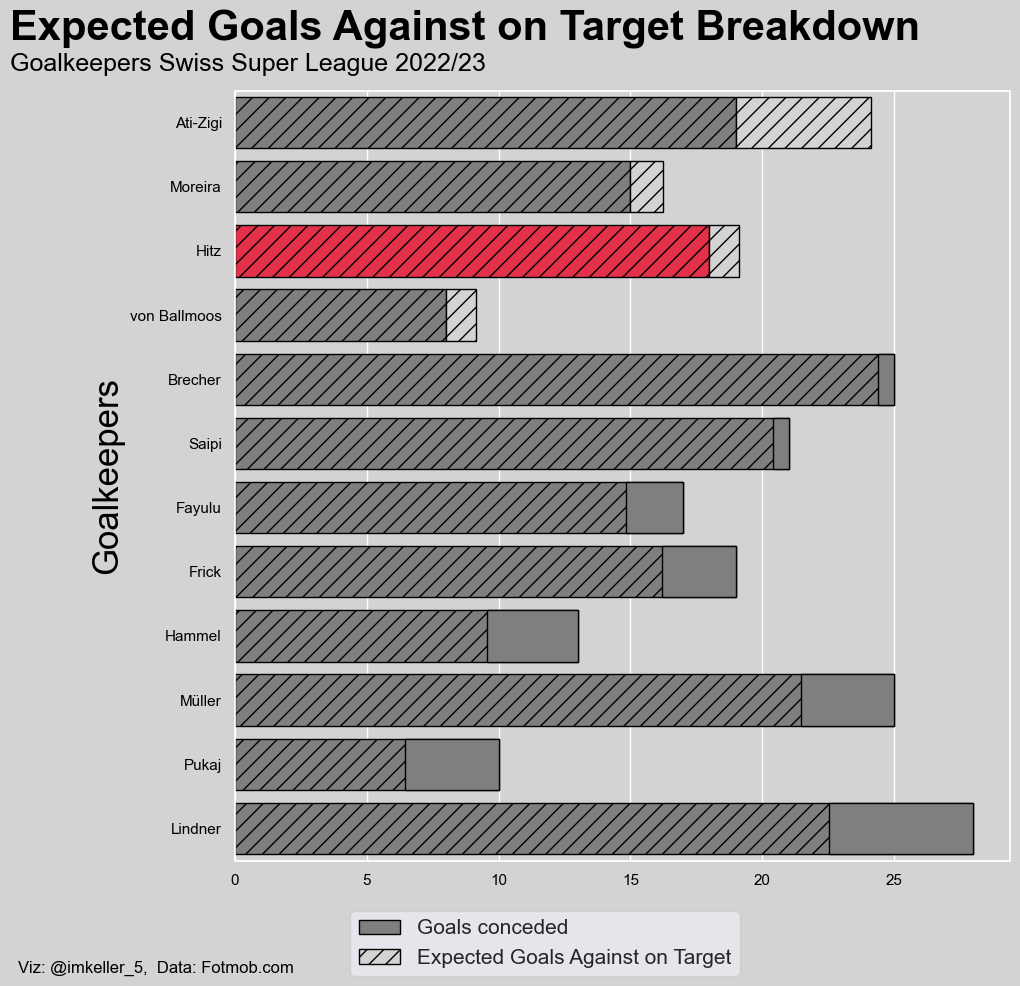

In [29]:
fig, ax = plt.subplots(figsize=(10,10))

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

mpl.rcParams['xtick.color'] = text_color  
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20


fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)

sns.barplot(
    y=df_goalies_ranking['keeper'],
    x=df_goalies_ranking['goals'],label='goals against',
    #color=CB_color_cycle[2],
    palette=[team_colors['BAS'] if x=='BAS' else mcolors.TABLEAU_COLORS['tab:gray'] for x in df_goalies_ranking['team_short']],
    alpha=1, 
    edgecolor='black',
    hatch='//'
    )
sns.barplot(
    y=df_goalies_ranking['keeper'],x=np.abs(df_goalies_ranking['goals_saved_above_expected']),
    label='expected goals against on target', 
    palette=[mcolors.TABLEAU_COLORS['tab:gray'] if x < 0 else background for x in df_goalies_ranking['goals_saved_above_expected']], 
    color=background,
    alpha=1,
    edgecolor='black',
    left=df_goalies_ranking.apply(lambda x: x['goals'] if x['goals_saved_above_expected'] > 0 else x['goals']+ x['goals_saved_above_expected'], axis=1),
    hatch=['//' if x > 0 else '' for x in df_goalies_ranking['goals_saved_above_expected']]
    )

patch_list = [
    patches.Rectangle(xy=(2,2), width=4, height= 4, facecolor=mcolors.TABLEAU_COLORS['tab:gray'], label='Goals conceded', edgecolor='black'),
    patches.Rectangle(xy=(1,1), width=4, height= 4, facecolor=background, label='Expected Goals Against on Target', hatch='//', edgecolor='black')
]
plt.legend(handles=patch_list, bbox_to_anchor=(0.4, -0.15), loc='lower center', borderaxespad=0, fontsize=15, frameon=True)

ax.set_ylabel('Goalkeepers',fontsize=25, color=text_color)
ax.set_xlabel('',fontsize=20)
fig.text(-0.1,0.93,'Expected Goals Against on Target Breakdown', fontsize=30, color=text_color, fontweight='bold')
fig.text(-0.1,0.90,'Goalkeepers Swiss Super League 2022/23', fontweight='regular',fontsize=18, color=text_color)

#ax.legend(loc="center left",bbox_to_anchor=(1, 0.5), frameon=True)
ax.annotate("Viz: @imkeller_5,  Data: Fotmob.com", (-8.25,13.25), annotation_clip=False, fontsize=12, color=text_color)
plt.show()

fig.savefig('figs/xgot-rsl-22-23.png',bbox_inches='tight')

## Expected Points Table

In [30]:
df_shots_xpt = df_shots[['match_id', 'shot_id', 'team_id', 'expected_goals','expected_goals_on_target','is_goal','team', 'team_short','opponent_id', 'opponent_team']]

In [31]:
df_teams['expected_goal_differential'] = df_teams['expected_goals_(xg)_sum'] - df_teams['expected_goals_against_(xga)_sum']


In [32]:
df_teams['goal_differential'] = df_teams['goals_sum'] - df_teams['goals_against_sum']

In [33]:
def calculate_xpts(df_shots, match_id, team_short):
    df_shots_single_game = df_shots[df_shots['match_id'] == match_id]
    xg_a = df_shots_single_game.loc[df_shots_single_game['team_short'] != team_short,'expected_goals'].values
    xg_b = df_shots_single_game.loc[df_shots_single_game['team_short'] == team_short,'expected_goals'].values

    poibin1 = PoiBin(xg_a)
    probs_a = poibin1.pmf.round(2)

    poibin2 = PoiBin(xg_b)
    probs_b = poibin2.pmf.round(2)

    outer_prod = np.outer(probs_a, probs_b)
    p_a = np.sum(np.triu(outer_prod, 1))
    #p_b = np.sum(np.tril(outer_prod, -1))
    p_draw = np.sum(np.diag(outer_prod))
    xpts_a = 3 * p_a + p_draw
    #xpts_b = 3 * p_b + p_draw
    return xpts_a.round(2)

In [34]:
df_games['expected_points_(xpts)'] = df_games.apply(lambda x: calculate_xpts(df_shots, x['match_id'], x['team_short']), axis=1)

In [35]:
df_teams['xpts_sum'] = df_teams['team_short'].apply(lambda x: df_games.loc[df_games['team_short'] == x, 'expected_points_(xpts)'].sum())
df_teams['xpts_mean'] = df_teams['team_short'].apply(lambda x: df_games.loc[df_games['team_short'] == x, 'expected_points_(xpts)'].mean())


In [36]:
df_games['points'] = df_games.apply(lambda x: 3 if x['goals'] > x['goals_against'] else 1 if x['goals'] == x['goals_against'] else 0, axis=1)
df_teams['points_sum'] = df_teams['team_short'].apply(lambda x: df_games.loc[df_games['team_short'] == x, 'points'].sum())
df_teams['points_mean'] = df_teams['team_short'].apply(lambda x: df_games.loc[df_games['team_short'] == x, 'points'].mean())

In [37]:
df_teams['points_over_expected'] = df_teams['points_sum'] - df_teams['xpts_sum']
df_teams['goal_differential_over_expected'] = df_teams['goal_differential'] - df_teams['expected_goal_differential']

In [38]:
df_teams['games_played'] = df_teams['team_short'].apply(lambda x: df_games.loc[df_games['team_short'] == x,'team_short'].shape[0])

In [39]:
df_teams.sort_values(by='points_sum', ascending=False).reset_index(inplace=True, drop=True)

In [40]:
df_teams['league_position'] = df_teams['points_sum'].rank(ascending=False, numeric_only=True)

In [41]:
df_teams['goal_differential_rank'] = df_teams['goal_differential'].rank(ascending=False, numeric_only=True)

In [42]:
df_teams[['league_position','goal_differential_rank']].sort_values(by='league_position', ascending=True)

,league_position,goal_differential_rank
9,1.0,1.0
7,2.0,2.0
3,3.0,5.0
5,4.0,6.5
4,5.0,4.0
2,6.0,6.5
0,7.0,3.0
6,8.0,8.0
1,9.5,9.0
8,9.5,10.0


In [43]:
s_ranks = df_teams[['team','league_position','goal_differential_rank']].sort_values(by='league_position', ascending=True).to_numpy()

In [44]:
for i in range(0, len(s_ranks)):
    if i < len(s_ranks)-1:
        if s_ranks[i][1] == s_ranks[i+1][1]:
            if s_ranks[i][2] < s_ranks[i+1][2]:
                s_ranks[i][1] = s_ranks[i][1] - 0.5
                s_ranks[i+1][1] = s_ranks[i+1][1] + 0.5
            else:
                if s_ranks[i][2] > s_ranks[i+1][2]:
                    s_ranks[i][1] = s_ranks[i][1] + 0.5
                    s_ranks[i+1][1] = s_ranks[i+1][1] - 0.5
            


In [45]:
test = dict()
for i in range(0, len(s_ranks)):
    test[s_ranks[i][0]] = s_ranks[i][1]

In [46]:
df_teams['league_position'] = df_teams['team'].map(lambda x: test[x])

In [47]:
df_teams['expected_league_position'] = df_teams['xpts_sum'].rank(ascending=False, numeric_only=True)

In [48]:
df_teams['leauge_position_over_expected'] = df_teams['expected_league_position'] - df_teams['league_position']

In [49]:
df_teams['logo_url'] = df_teams['team_short'].map(team_logo_url)

In [50]:
df_teams

,team,team_short,ball_possession_mean,expected_goals_(xg)_mean,total_shots_mean,big_chances_mean,big_chances_missed_mean,accurate_passes_mean,fouls_committed_mean,offsides_mean,corners_mean,shots_off_target_mean,shots_on_target_mean,blocked_shots_mean,hit_woodwork_mean,shots_inside_box_mean,shots_outside_box_mean,xg_first_half_mean,xg_second_half_mean,xg_open_play_mean,xg_set_play_mean,xg_penalty_mean,xg_on_target_(xgot)_mean,passes_mean,own_half_mean,opposition_half_mean,accurate_long_balls_mean,accurate_crosses_mean,throws_mean,tackles_won_mean,interceptions_mean,blocks_mean,clearances_mean,keeper_saves_mean,duels_won_mean,ground_duels_won_mean,aerial_duels_won_mean,successful_dribbles_mean,yellow_cards_mean,red_cards_mean,goals_mean,goals_against_mean,pass_accuracy_mean,longball_accuracy_mean,cross_accuracy_mean,tackles_won_percentage_mean,ground_duels_won_percentage_mean,aerial_duels_won_percentage_mean,successful_dribbles_percentage_mean,expected_goals_against_(xga)_mean,xga_first_half_mean,xga_second_half_mean,xga_open_play_mean,xga_set_play_mean,xga_on_target_(xgaot)_mean,xga_penalty_mean,goals_against_over_expected_mean,goals_over_expected_mean,ball_possession_sum,expected_goals_(xg)_sum,total_shots_sum,big_chances_sum,big_chances_missed_sum,accurate_passes_sum,fouls_committed_sum,offsides_sum,corners_sum,shots_off_target_sum,shots_on_target_sum,blocked_shots_sum,hit_woodwork_sum,shots_inside_box_sum,shots_outside_box_sum,xg_first_half_sum,xg_second_half_sum,xg_open_play_sum,xg_set_play_sum,xg_penalty_sum,xg_on_target_(xgot)_sum,passes_sum,own_half_sum,opposition_half_sum,accurate_long_balls_sum,accurate_crosses_sum,throws_sum,tackles_won_sum,interceptions_sum,blocks_sum,clearances_sum,keeper_saves_sum,duels_won_sum,ground_duels_won_sum,aerial_duels_won_sum,successful_dribbles_sum,yellow_cards_sum,red_cards_sum,goals_sum,goals_against_sum,pass_accuracy_sum,longball_accuracy_sum,cross_accuracy_sum,tackles_won_percentage_sum,ground_duels_won_percentage_sum,aerial_duels_won_percentage_sum,successful_dribbles_percentage_sum,expected_goals_against_(xga)_sum,xga_first_half_sum,xga_second_half_sum,xga_open_play_sum,xga_set_play_sum,xga_on_target_(xgaot)_sum,xga_penalty_sum,goals_against_over_expected_sum,goals_over_expected_sum,expected_goal_differential,goal_differential,xpts_sum,xpts_mean,points_sum,points_mean,points_over_expected,goal_differential_over_expected,games_played,league_position,goal_differential_rank,expected_league_position,leauge_position_over_expected,logo_url
0,Basel,BAS,55.947368,1.567895,15.157895,2.210526,1.421053,370.947368,11.947368,2.157895,6.578947,6.263158,5.421053,3.473684,0.473684,10.421053,4.736842,0.627368,0.940526,0.970526,0.432105,0.165789,1.626316,452.210526,185.157895,185.789474,29.052632,5.368421,22.789474,8.842105,8.157895,3.526316,15.578947,2.526316,44.842105,33.894737,10.947368,8.157895,2.421053,0.105263,1.263158,1.157895,81.105263,52.000000,27.157895,64.684211,47.473684,49.105263,47.578947,1.296316,0.492632,0.804737,0.855789,0.274211,1.357368,0.165789,-0.138421,-0.304737,1063,29.79,288,42,27,7048,227,41,125,119,103,66,9,198,90,11.92,17.87,18.44,8.21,3.15,30.90,8592,3518,3530,552,102,433,168,155,67,296,48,852,644,208,155,46,2,24,22,1541,988,516,1229,902,933,904,24.63,9.36,15.29,16.26,5.21,25.79,3.15,-2.63,-5.79,5.16,2,28.36,1.492632,22,1.157895,-6.36,-3.16,19,7.0,3.0,5.0,-2.0,https://images.fotmob.com/image_resources/logo...
1,FC Zürich,ZUR,49.368421,1.234211,12.894737,1.736842,1.157895,290.842105,12.210526,2.000000,4.368421,5.315789,4.263158,3.315789,0.157895,7.947368,4.947368,0.451579,0.782632,0.847895,0.219474,0.166316,1.136316,389.736842,146.789474,144.052632,27.473684,4.368421,25.315789,9.052632,10.684211,2.789474,15.894737,2.947368,45.789474,33.000000,12.789474,6.526316,2.894737,0.210526,0.894737,1.526316,73.578947,42.473684,28.842105,61.684211,49.736842,47.789474,48.842105,1.077895,0.473684,0.603158,0.803684,0.232105,1.548947,0.041053,0.448421,-0.339474,938,23.45,245,33,22,5526,2

In [51]:
df_teams['Team'] = df_teams['team_short'].map(team_names)

In [52]:
df_teams = df_teams.set_index('Team')

In [53]:
plt.rcParams["font.family"] = ["DejaVu Sans"]
plt.rcParams["savefig.bbox"] = "tight"

In [54]:
df_teams.loc[df_teams['team_short'] == 'YB', 'logo_url'] = 'resources/YB.png'
df_teams.loc[df_teams['team_short'] == 'LUZ', 'logo_url'] = 'resources/FCL.png'
df_teams.loc[df_teams['team_short'] == 'BAS', 'logo_url'] = 'resources/FCB.png'
df_teams.loc[df_teams['team_short'] == 'WIN', 'logo_url'] = 'resources/FCW.png'
df_teams.loc[df_teams['team_short'] == 'GAL', 'logo_url'] = 'resources/GAL.png'
df_teams.loc[df_teams['team_short'] == 'ZUR', 'logo_url'] = 'resources/FCZ.png'
df_teams.loc[df_teams['team_short'] == 'GRA', 'logo_url'] = 'resources/GCZ.png'
df_teams.loc[df_teams['team_short'] == 'SIO', 'logo_url'] = 'resources/SIO.png'
df_teams.loc[df_teams['team_short'] == 'SER', 'logo_url'] = 'resources/SER.png'
df_teams.loc[df_teams['team_short'] == 'LUG', 'logo_url'] = 'resources/LUG.png'

In [55]:
df_teams.sort_values(by='points_sum', ascending=False, inplace=True)
df_table = df_teams[[
    'logo_url',
    'games_played',
    'league_position',
    'expected_league_position',
    'leauge_position_over_expected',
    'points_sum',
    'xpts_sum',
    'points_over_expected',
    'goal_differential',
    'expected_goal_differential',
    'goal_differential_over_expected',
    ]].round(2).copy()
df_table[[
    'league_position',
    'expected_league_position',
    'leauge_position_over_expected',
    'points_sum'
    ]] = df_table[[
    'league_position',
    'expected_league_position',
    'leauge_position_over_expected',
    'points_sum'
    ]].astype(int)

In [56]:
font_cols = [
    'points_sum',
    'xpts_sum',
    'points_over_expected',
    'goal_differential',
    'expected_goal_differential',
    'goal_differential_over_expected',
    'league_position',
    'expected_league_position',
    'leauge_position_over_expected'
]

In [67]:
col_defs = (
    [
        ColumnDefinition(
            name="Team",
            title="Team",
            textprops={"ha": "center"},
            width=1.5,
        ),
        ColumnDefinition(
            name="logo_url",
            title="",
            textprops={"ha": "center"},
            width=0.5,
            plot_fn=image,
        ),
        ColumnDefinition(
            name="games_played",
            title="Games",
            textprops={"ha": "center"},
            width=0.5,
        ),
        ColumnDefinition(
            name="league_position",
            title="League\nPosition",
            textprops={"ha": "center"},
            width=1,
        ),
        ColumnDefinition(
            name="expected_league_position",
            title="Expected\nLeague\nPosition",
            textprops={"ha": "center"},
            width=1,
        ),
        ColumnDefinition(
            name="leauge_position_over_expected",
            title="League\nPosition\nover expected",
            cmap=normed_cmap(df_teams['leauge_position_over_expected'], cmap=mpl.cm.PiYG, num_stds=2.5),
            textprops={"ha": "center"},
            width=1,
        ),
        ColumnDefinition(
            name='points_sum',
            title="Points",
            textprops={"ha": "center"},
            width=1,
        ),
        ColumnDefinition(
            name="xpts_sum",
            title="Expected\nPoints",
            textprops={"ha": "center"},
            width=1,
        ),
        ColumnDefinition(
            name="points_over_expected",
            title="Points\nover expected",
            cmap=normed_cmap(df_teams['points_over_expected'], cmap=mpl.cm.PiYG, num_stds=2.5),
            textprops={"ha": "center"},
            width=1,
        ),  
        ColumnDefinition(
            name="goal_differential",
            title="Goal\nDifferential",
            textprops={"ha": "center"},
            width=1,
        ),
        ColumnDefinition(
            name="expected_goal_differential",
            title="Expected\nGoal\nDifferential",
            textprops={"ha": "center"},
            width=1,
        ),
        ColumnDefinition(
            name="goal_differential_over_expected",
            title="Goal\nDifferential \nover Expected",
            cmap=normed_cmap(df_teams['goal_differential_over_expected'], cmap=mpl.cm.PiYG, num_stds=2.5),
            textprops={"ha": "center"},
            width=1,
        ),
    ]
)

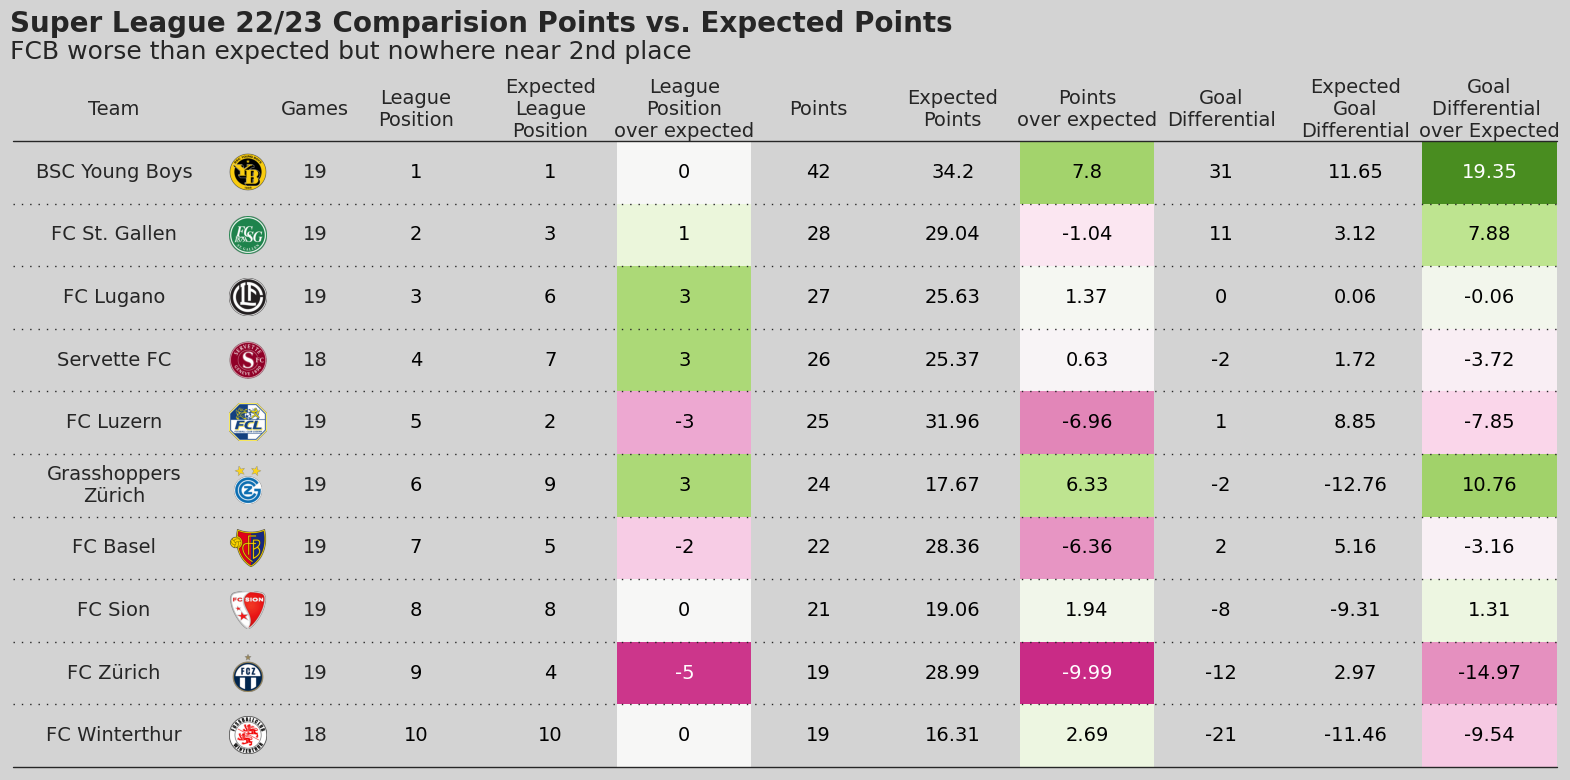

In [68]:
fig, ax = plt.subplots(figsize=(20, 9))

fig.set_facecolor(background)
ax.patch.set_alpha(0)

fig.text(0.125,0.93,'Super League 22/23 Comparision Points vs. Expected Points', fontsize=20, fontweight='bold')
fig.text(0.125,0.90,'FCB worse than expected but nowhere near 2nd place', fontweight='regular',fontsize=18)

season = "2022/23"
text_color = "black"
background = "#D3D3D3"
edge = "white"

table = Table(
    df_table,
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    textprops={"fontsize": 14},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
).autoset_fontcolors(colnames=(font_cols))

fig.savefig('figs/xpts-rsl-22-23.png',bbox_inches='tight')